In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torchvision import models
from torchinfo import summary
from torch import optim

In [2]:
IMG_SIZE = 224
NUM_CLASSES = 6

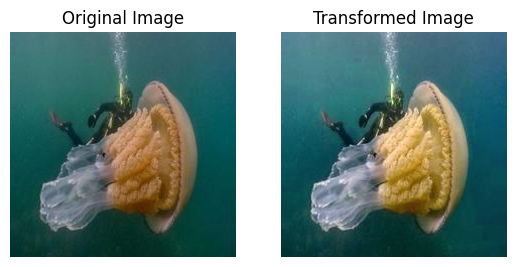

In [3]:
# Load the image
image_path = 'Train_Test_Valid/train/barrel_jellyfish/17.jpg'  # Replace with the path to your image
original_image = Image.open(image_path).convert("RGB")

# Define the transformation
transform = transforms.ColorJitter(brightness= 0.2, contrast=0.2, saturation=0.2, hue=0.1)
# Apply the transformation
transformed_image = transform(original_image)


# Display the original and transformed images
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Transformed Image')
plt.axis('off')


plt.show()

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.dataset = datasets.ImageFolder(root=os.path.join(root, split), transform=transform)
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)
        
dataset_root = 'Train_Test_Valid'

# Create datasets with and without augmentation
#train_dataset_augmented = CustomDatasetWithAugmentation(root=dataset_root, split='train', transform=train_transform)
train_dataset = CustomDataset(root=dataset_root, split='train', transform=train_transform)
test_dataset = CustomDataset(root=dataset_root, split='test', transform=val_test_transform)
valid_dataset = CustomDataset(root=dataset_root, split='valid', transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)


train_loader.dataset.__len__(), test_loader.dataset.__len__(), valid_loader.dataset.__len__()


(900, 40, 39)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
vit = models.vit_b_16().to(device)

In [7]:
vit.head = nn.Linear(796, NUM_CLASSES)

In [8]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

# Training loop with model checkpointing
num_epochs = 30 
best_accuracy = 0.0

for epoch in range(num_epochs):
    vit.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    vit.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vit(inputs)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')

        # Save the model if the current accuracy is better than the previous best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(vit.state_dict(), 'vit_model_checkpoint.pth')
    torch.cuda.empty_cache()
# Load the best model checkpoint for testing
vit.load_state_dict(torch.load('vit_model_checkpoint.pth'))
vit.eval()

# Testing loop
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vit(inputs)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/30, Loss: 1.7816, Validation Accuracy: 0.1795
Epoch 2/30, Loss: 1.7909, Validation Accuracy: 0.1538
Epoch 3/30, Loss: 1.7076, Validation Accuracy: 0.1795
Epoch 4/30, Loss: 1.7302, Validation Accuracy: 0.1795
Epoch 5/30, Loss: 1.7791, Validation Accuracy: 0.1795
Epoch 6/30, Loss: 1.7783, Validation Accuracy: 0.1795
Epoch 7/30, Loss: 1.6717, Validation Accuracy: 0.1795
Epoch 8/30, Loss: 1.6092, Validation Accuracy: 0.2564
Epoch 9/30, Loss: 1.7253, Validation Accuracy: 0.2051
Epoch 10/30, Loss: 1.0520, Validation Accuracy: 0.2821
Epoch 11/30, Loss: 1.8454, Validation Accuracy: 0.3333
Epoch 12/30, Loss: 2.1625, Validation Accuracy: 0.2821
Epoch 13/30, Loss: 1.3266, Validation Accuracy: 0.2821
Epoch 14/30, Loss: 1.3972, Validation Accuracy: 0.2821
Epoch 15/30, Loss: 1.5896, Validation Accuracy: 0.3846
Epoch 16/30, Loss: 2.8549, Validation Accuracy: 0.3333
Epoch 17/30, Loss: 1.3215, Validation Accuracy: 0.3846
Epoch 18/30, Loss: 1.4327, Validation Accuracy: 0.3590
Epoch 19/30, Loss: 